In [6]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

In [2]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../../data/regional_datasets/univariate/esc_data_univ.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/univariate/mid_atlantic_data_univ.csv')
mountain = pd.read_csv('../../data/regional_datasets/univariate/mountain_data_univ.csv')
new_england = pd.read_csv('../../data/regional_datasets/univariate/new_england_data_univ.csv')
pacific = pd.read_csv('../../data/regional_datasets/univariate/pacific_data_univ.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/univariate/south_atlantic_data_univ.csv')
wnc = pd.read_csv('../../data/regional_datasets/univariate/wnc_data_univ.csv')
wsc = pd.read_csv('../../data/regional_datasets/univariate/wsc_data_univ.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.set_index(pd.to_datetime(df['date']), inplace=True)
    df.drop(columns=["Unnamed: 0", "date"], axis=1, inplace=True)
    df.sort_index(inplace=True)
    


In [3]:
# ignore values before march 
enc = enc[enc.index >= "2020-03-01"]
esc = esc[esc.index >= "2020-03-01"]
mid_atlantic = mid_atlantic[mid_atlantic.index >= "2020-03-01"]
mountain = mountain[mountain.index >= "2020-03-01"]
new_england = new_england[new_england.index >= "2020-03-01"]
pacific = pacific[pacific.index >= "2020-03-01"]
south_atlantic = south_atlantic[south_atlantic.index >= "2020-03-01"]
wnc = wnc[wnc.index >= "2020-03-01"]
wsc = wsc[wsc.index >= "2020-03-01"]

# ARIMA

In [40]:
def build_arima_model(df, params=None, plot=False, test_perf = False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])

    if not params:
        params = (7,1,7)

    # validation step
    
    model = ARIMA(train, order=params)
    model_fit = model.fit()

    val_pred = model_fit.forecast(steps=len(val))
    
    mae = round(mean_absolute_error(val, val_pred), 2)
    rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
    aic = round(model_fit.aic, 2)

    print(f"Validatation Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
   
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Validation ARIMA Predictions for {region}')
        plt.plot(val.index, val, label='True Val')
        plt.plot(val_pred.index, val_pred, label='Predicted')
        plt.legend() 
        plt.show()

    # test 
    if test_perf:
        model = ARIMA(train_val, order=params)
        model_fit = model.fit()

        test_pred = model_fit.forecast(steps=len(test))
        test_pred[test_pred < 0] = 0
        mae = round(mean_absolute_error(test, test_pred), 2)
        rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
        mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train_val), 2)
        aic = round(model_fit.aic, 2)

        print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
        
        # plot both validation and test
        # if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Test ARIMA Predictions for {region}')
        # plt.plot(val.index, val, label='True Val', color="#1f77b4")
        # plt.plot(val_pred.index, val_pred, label='Val Predicted', color="purple")
        plt.plot(test.index, test, label='True Test')
        plt.plot(test_pred.index, test_pred, label='Test Predicted')
        plt.legend() 
        plt.show()

    print(f"Training for {region} complete")

Training model for East North Central...
Validatation Stats= AIC: 16410.72, MASE: 0.98, RMSE: 12726.25, MAE: 8054.3


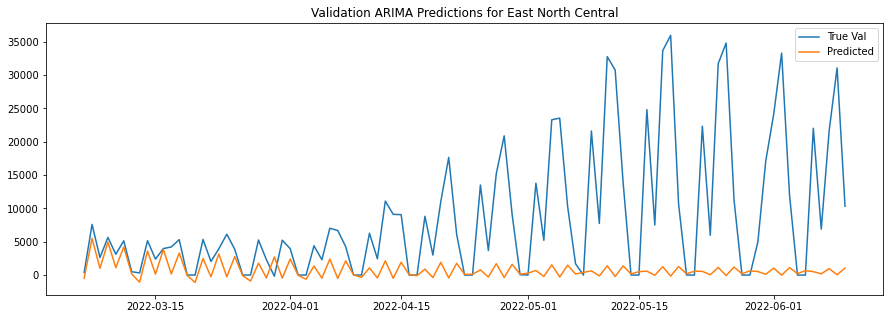

Test Stats= AIC: 18385.75, MASE: 0.94, RMSE: 9445.32, MAE: 7695.41


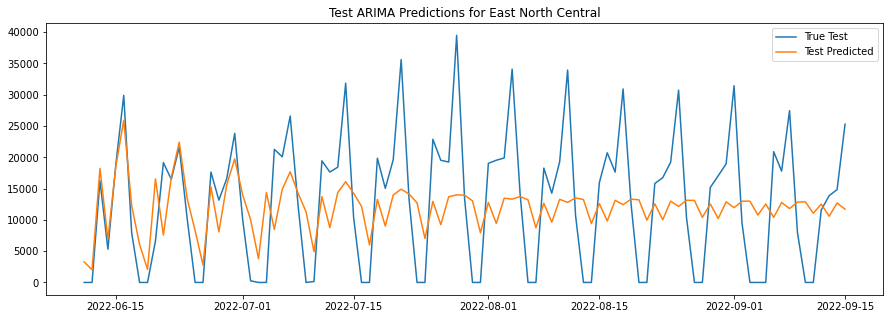

Training for East North Central complete

Training model for East South Central...
Validatation Stats= AIC: 15520.32, MASE: 0.69, RMSE: 2935.8, MAE: 2355.08


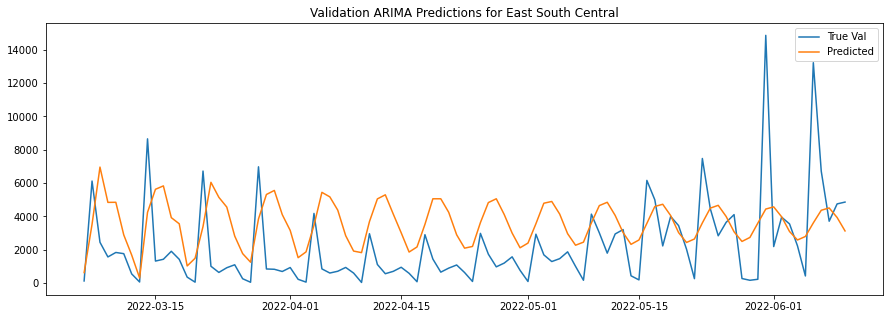

Test Stats= AIC: 17371.5, MASE: 1.5, RMSE: 6849.67, MAE: 4873.39


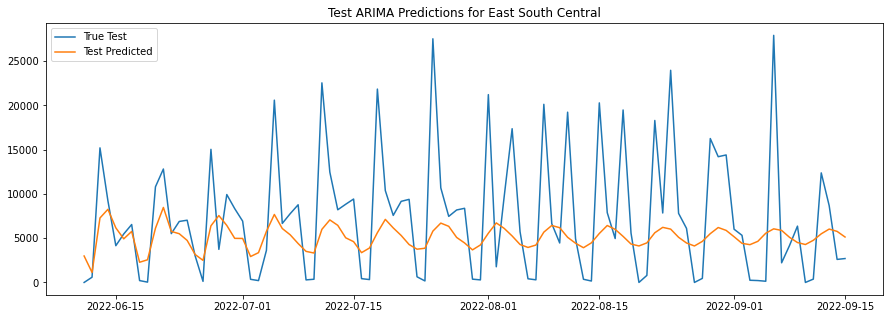

Training for East South Central complete

Training model for Mid-Atlantic...
Validatation Stats= AIC: 15199.92, MASE: 3.69, RMSE: 10606.82, MAE: 7893.92


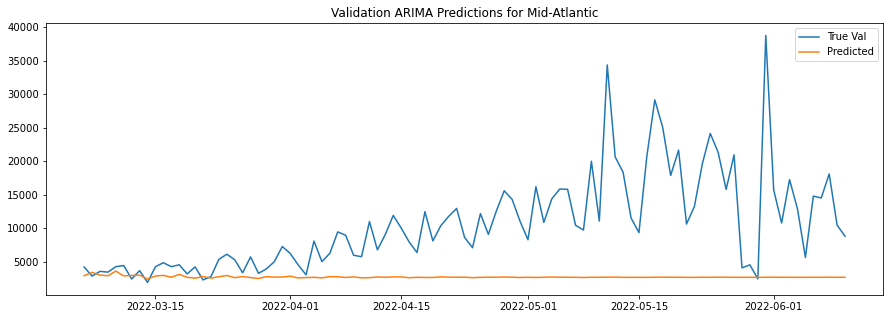

Test Stats= AIC: 17149.62, MASE: 3.83, RMSE: 10877.17, MAE: 9066.03


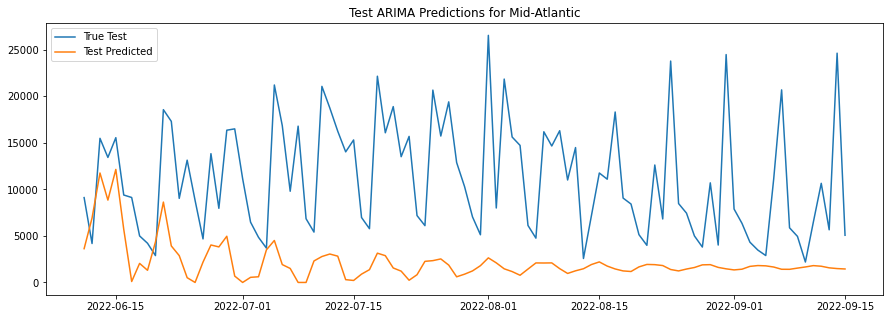

Training for Mid-Atlantic complete

Training model for Mountain...
Validatation Stats= AIC: 15558.2, MASE: 0.97, RMSE: 5063.69, MAE: 3065.24


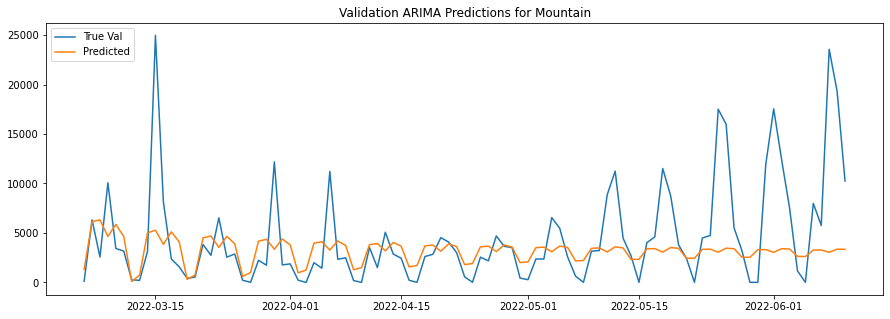

Test Stats= AIC: 17455.26, MASE: 2.93, RMSE: 10290.35, MAE: 9354.16


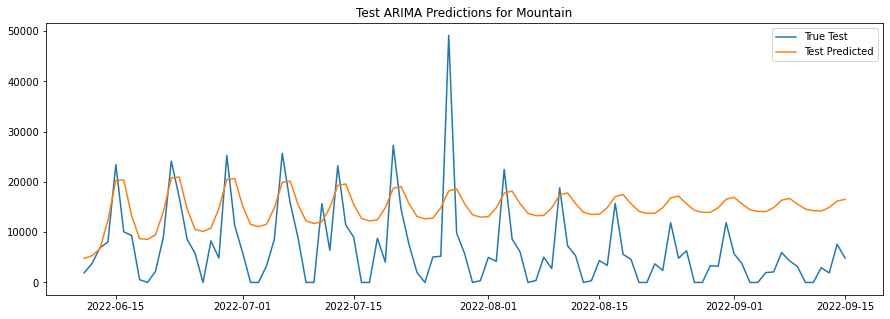

Training for Mountain complete

Training model for New England...
Validatation Stats= AIC: 15273.82, MASE: 1.38, RMSE: 5300.61, MAE: 3500.2


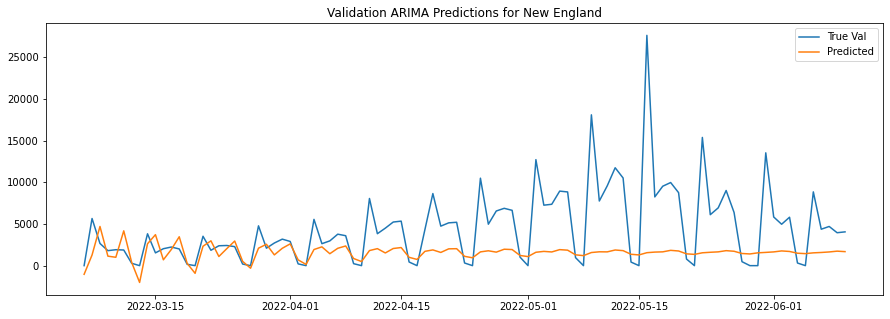

Test Stats= AIC: 17129.27, MASE: 0.91, RMSE: 3235.99, MAE: 2385.25


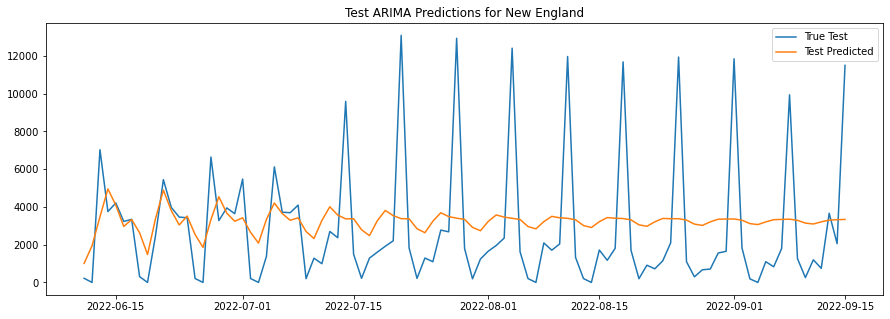

Training for New England complete

Training model for Pacific...
Validatation Stats= AIC: 16625.71, MASE: 1.39, RMSE: 16297.11, MAE: 9373.06


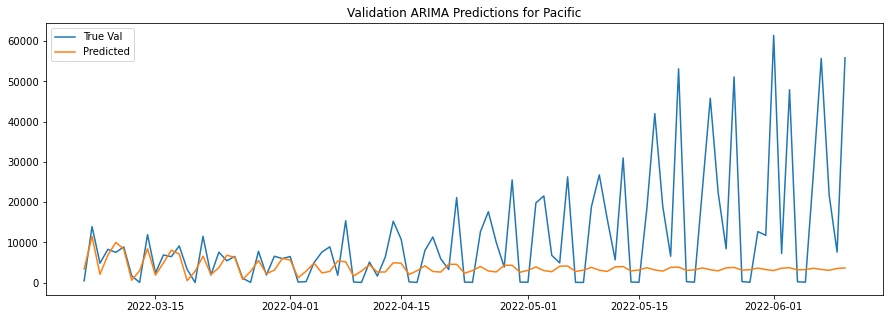

Test Stats= AIC: 18691.56, MASE: 1.99, RMSE: 17107.85, MAE: 14801.13


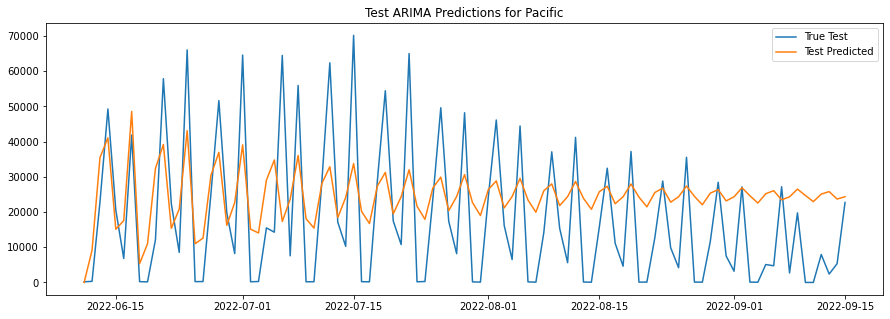

Training for Pacific complete

Training model for South Atlantic...
Validatation Stats= AIC: 17328.69, MASE: 0.82, RMSE: 14481.7, MAE: 8933.92


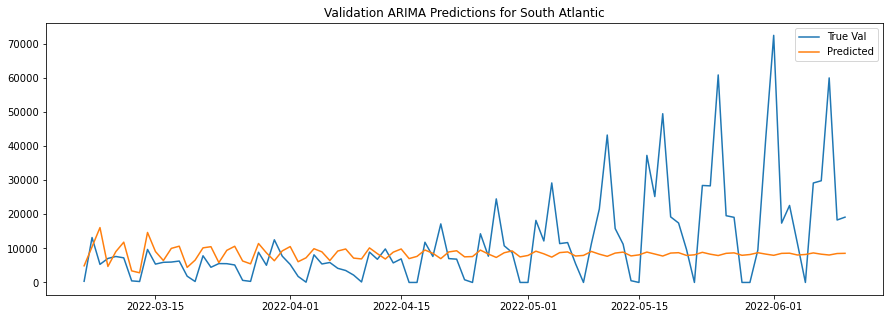

Test Stats= AIC: 19423.51, MASE: 1.6, RMSE: 21222.43, MAE: 17055.91


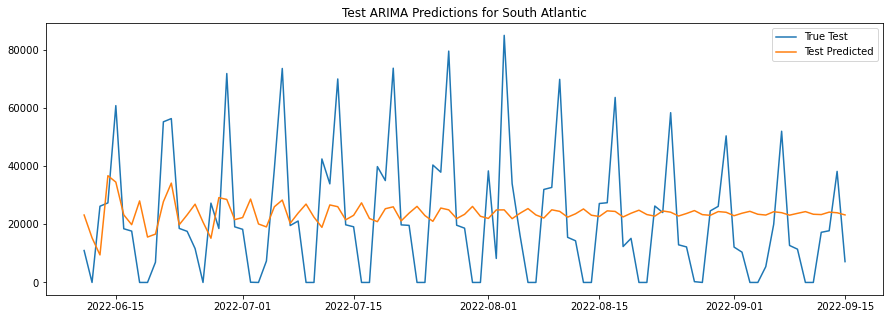

Training for South Atlantic complete

Training model for West North Central...
Validatation Stats= AIC: 15393.03, MASE: 1.09, RMSE: 4177.42, MAE: 3562.78


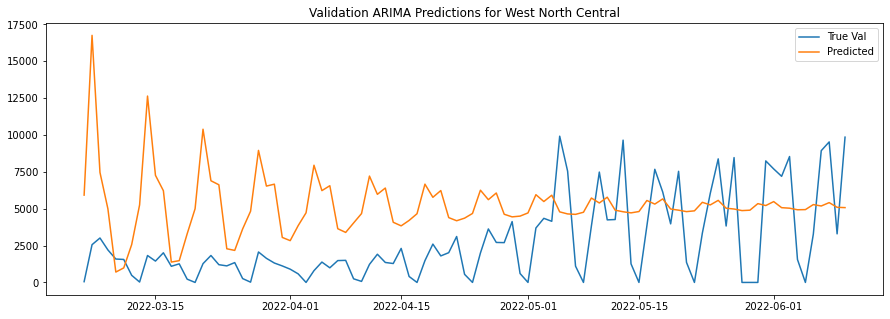

Test Stats= AIC: 17239.45, MASE: 1.2, RMSE: 4253.16, MAE: 3750.87


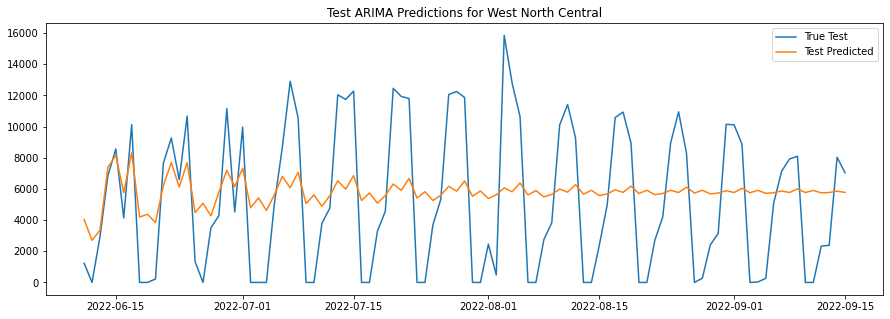

Training for West North Central complete

Training model for West South Central...
Validatation Stats= AIC: 16227.65, MASE: 0.56, RMSE: 3809.27, MAE: 2530.06


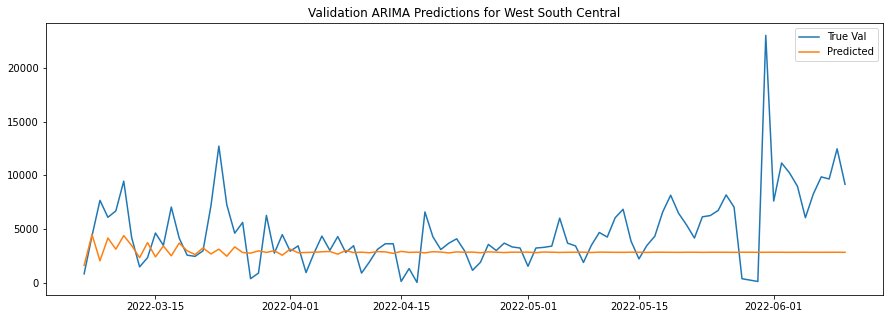

Test Stats= AIC: 18171.69, MASE: 1.65, RMSE: 9167.54, MAE: 7087.33


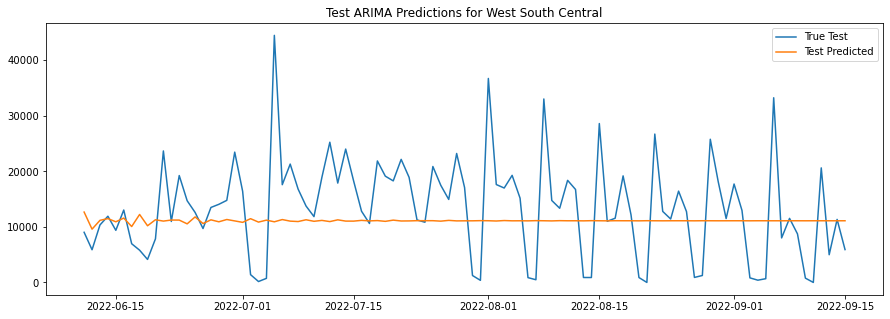

Training for West South Central complete

--- 158.63 seconds ---


In [41]:
start_time = time.time()
for df in datasets:
    build_arima_model(df, plot=True, test_perf=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Parameter Optimization

In [36]:
def parameter_tune(df):
    region = df["region"].iloc[0]
    print(f"Optimizing model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])
    # validation step
    


    results = []
    for p in range(5, 9):
        for d in range(2):
            for q in range(5, 9):
                model = ARIMA(train, order=(p,d,q))
                model_fit = model.fit()

                # pred = model_fit.forecast(steps=size)

                val_pred = model_fit.forecast(steps=len(val))
    
                mae = round(mean_absolute_error(val, val_pred), 2)
                rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
                mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
                aic = round(model_fit.aic, 2)

                results.append([p, d, q, model_fit.aic, mae, rmse, mase])
                
    results = pd.DataFrame(results, columns=["p", "d", "q", "aic", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())

In [37]:
start_time = time.time()
for df in datasets:
    parameter_tune(df)
    print("")

print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Optimizing model for East North Central...
    p  d  q           aic      mae      rmse  mase
16  7  0  5  16462.872510  6452.50   9092.69  0.79
18  7  0  7  16446.412852  6548.91   9031.82  0.80
17  7  0  6  16444.072178  6542.09   9012.92  0.80
31  8  1  8  16396.709076  6711.20  11053.22  0.82
19  7  0  8  16431.781315  6704.93   9026.64  0.82

Optimizing model for East South Central...
    p  d  q           aic      mae     rmse  mase
31  8  1  8  15504.553657  1808.11  2667.95  0.53
30  8  1  7  15511.085121  1836.72  2741.18  0.54
29  8  1  6  15536.101981  2092.59  3308.98  0.61
28  8  1  5  15533.969402  2066.59  3290.28  0.61
6   5  1  7  15532.968152  2294.71  2898.20  0.67

Optimizing model for Mid-Atlantic...
    p  d  q           aic      mae     rmse  mase
11  6  0  8  15234.340969  4178.27  5885.92  1.95
24  8  0  5  15324.092093  4285.99  6535.51  2.00
19  7  0  8  15210.150996  4307.86  5934.24  2.01
18  7  0  7  15208.300645  4349.72  5957.58  2.03
27  8  0  8  15211.

## Final ARIMA

In [38]:

params = {
    "East North Central": (7, 0, 5),
    "East South Central": (8, 1, 8),
    "Mid-Atlantic": (6, 0, 8),
    "Mountain": (7, 1, 7),  
    "New England": (8, 0, 5),
    "Pacific": (8, 1, 6),
    "South Atlantic": (8, 0, 5),
    "West North Central": (5, 1, 6),
    "West South Central": (8, 1, 8),
}

In [39]:
def final_arima_model(df, params=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])

    if not params:
        params = (4,1,4)

    # validation step
    
    model = ARIMA(train_val, order=params)
    model_fit = model.fit()

    test_pred = model_fit.forecast(steps=len(test))
    test_pred[test_pred < 0] = 0

    mae = round(mean_absolute_error(test, test_pred), 2)
    rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train_val), 2)
    aic = round(model_fit.aic, 2)
    

    print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
   
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Test ARIMA Predictions for {region}')
        plt.plot(test.index, test, label='True Test')
        plt.plot(test_pred.index, test_pred, label='Predicted')
    
        plt.legend() 
        plt.show()



Training model for East North Central...
Test Stats= AIC: 18441.96, MASE: 0.99, RMSE: 9464.92, MAE: 8048.61


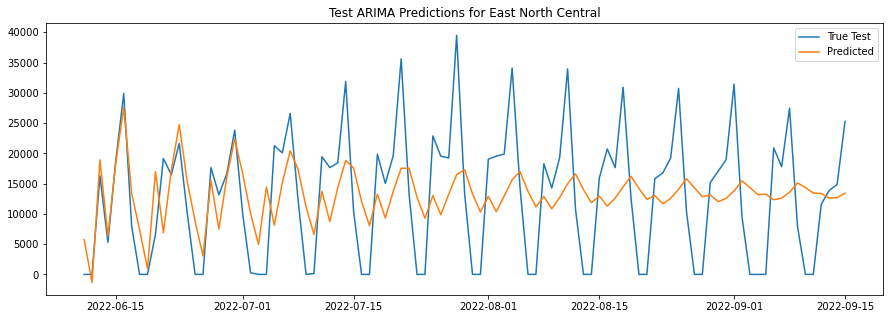


Training model for East South Central...
Test Stats= AIC: 17359.69, MASE: 1.49, RMSE: 6675.0, MAE: 4868.6


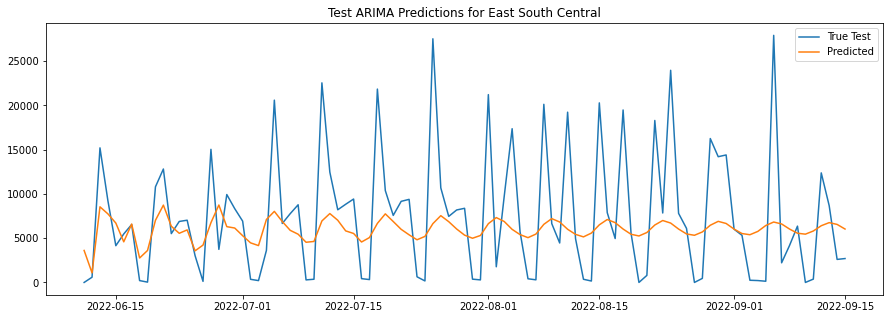


Training model for Mid-Atlantic...
Test Stats= AIC: 17170.99, MASE: 2.35, RMSE: 6403.6, MAE: 5547.38


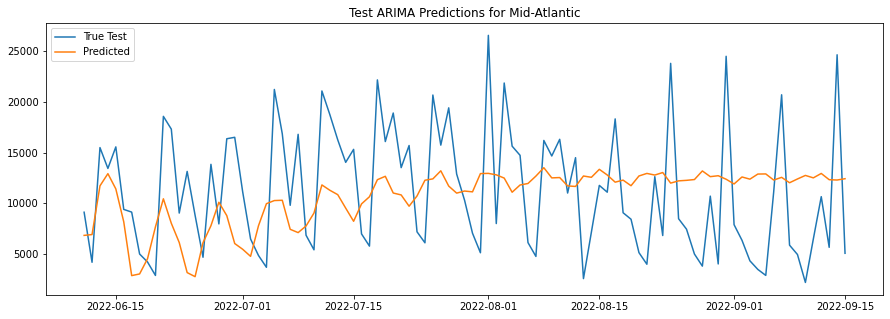


Training model for Mountain...
Test Stats= AIC: 17455.26, MASE: 2.93, RMSE: 10290.35, MAE: 9354.16


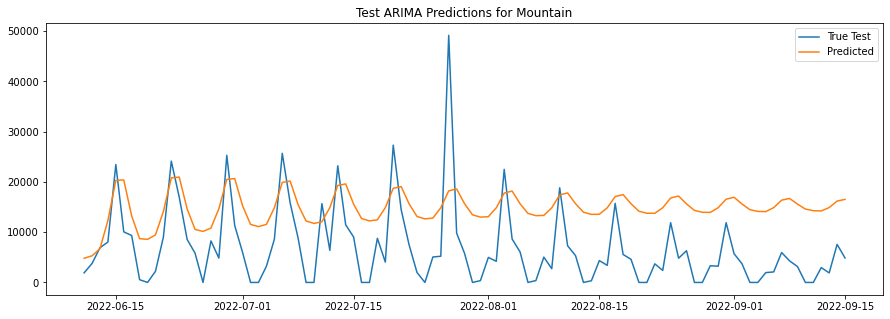


Training model for New England...
Test Stats= AIC: 17159.35, MASE: 1.06, RMSE: 3424.46, MAE: 2785.72


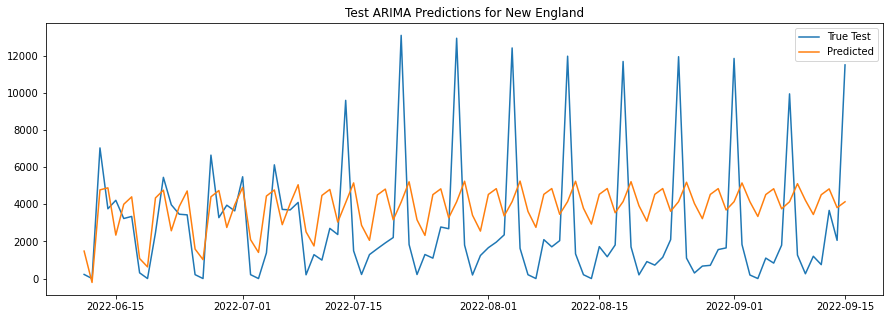


Training model for Pacific...
Test Stats= AIC: 18694.64, MASE: 1.71, RMSE: 15370.97, MAE: 12721.49


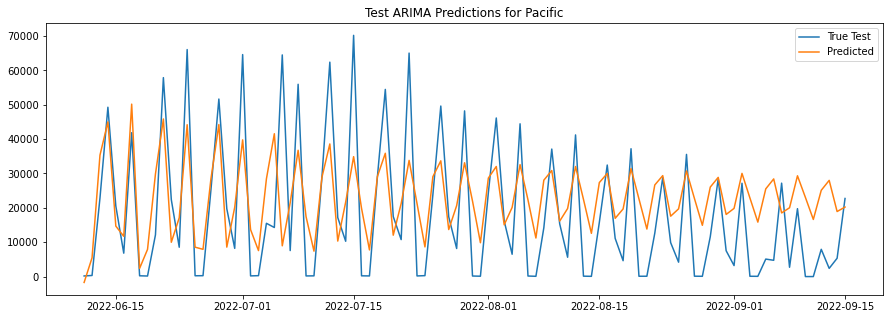


Training model for South Atlantic...
Test Stats= AIC: 19460.05, MASE: 1.42, RMSE: 18975.75, MAE: 15188.59


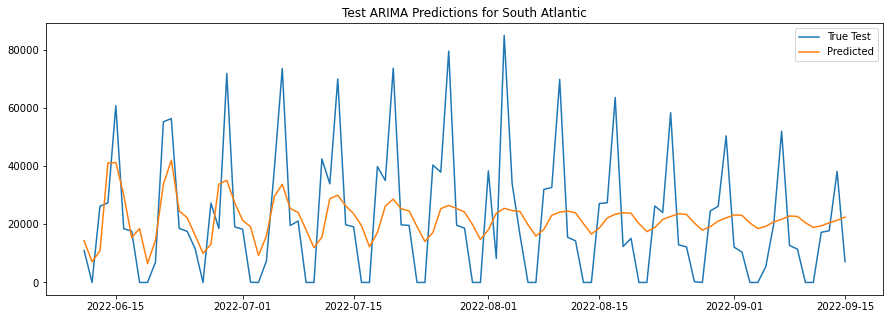


Training model for West North Central...
Test Stats= AIC: 17336.11, MASE: 1.3, RMSE: 4522.21, MAE: 4051.74


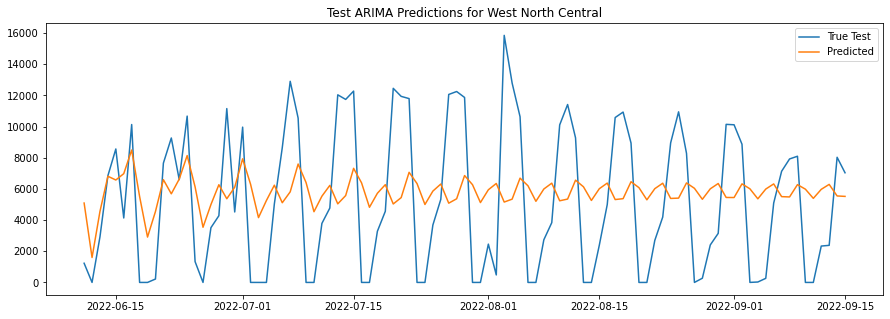


Training model for West South Central...
Test Stats= AIC: 18164.37, MASE: 1.7, RMSE: 9328.11, MAE: 7307.92


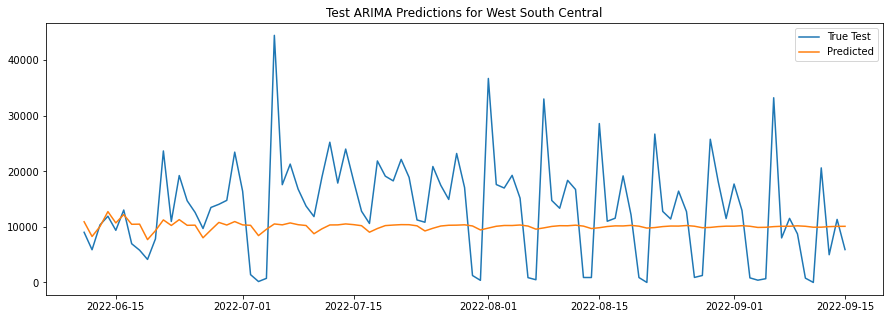


--- 53.46 seconds ---


In [40]:
start_time = time.time()
for df in datasets:
    final_arima_model(df, params=params[df["region"].iloc[0]], plot=True)
    print("")

print(f"--- {round(time.time() - start_time, 2)} seconds ---")